In [1]:
import http.client
import pandas as pd
import pprint
import collections
from datetime import datetime

start_date='01/01/2016'
end_date='01/01/2030'

current_date = datetime.now()
# current_date = datetime.strptime("2020-11-30", "%Y-%m-%d")

url = "https://ptax.bcb.gov.br/ptax_internet/consultaBoletim.do?method=gerarCSVFechamentoMoedaNoPeriodo&ChkMoeda=61&DATAINI={start}&DATAFIM={end}".format(start=start_date, end=end_date)

retry = 20
while retry != 0:
  try:
    data = pd.read_csv(url, header=None, sep=";", dtype=str)
    break
  except http.client.RemoteDisconnected:
    retry -= 1
    
data

,0,1,2,3,4,5,6,7
0,04012016,220,A,USD,"4,0380","4,0387","1,0000","1,0000"
1,05012016,220,A,USD,"4,0108","4,0114","1,0000","1,0000"
2,06012016,220,A,USD,"4,0297","4,0303","1,0000","1,0000"
3,07012016,220,A,USD,"4,0469","4,0475","1,0000","1,0000"
4,08012016,220,A,USD,"4,0244","4,0250","1,0000","1,0000"
...,...,...,...,...,...,...,...,...
1336,04052021,220,A,USD,"5,4499","5,4505","1,0000","1,0000"
1337,05052021,220,A,USD,"5,3866","5,3872","1,0000","1,0000"
1338,06052021,220,A,USD,"5,2891","5,2897","1,0000","1,0000"
1339,07052021,220,A,USD,"5,2211","5,2217","1,0000","1,0000"


In [2]:
rates = {}
for row in data.to_numpy():
    row_date = datetime.strptime(row[0], "%d%m%Y").strftime("%Y-%m-%d")
    row_value = {"BRL": float(row[5].replace(",","."))}
    rates[row_date] = row_value

In [3]:
def group_by_month(dictionary):
    output = {}
    for key in dictionary:
        month_key = key[:7]
        day = int(key[8:])
        if month_key in output:
            rate_list = output[month_key]
            rate_list[day] = dictionary[key]['BRL']
            output[month_key] = rate_list
        else:
            output[month_key] = {day: dictionary[key]['BRL']}
    return output

def normalize_values(dictionary, min_value, max_value):
    output = dictionary.copy()
    delta = max_value - min_value
    for key in output:
        value = output[key]
        if (delta != 0):
            output[key] = (value - min_value)/delta
        else:
            output[key] = 1
    return output
        

def make_rates_relative(dictionary):
    grouped_rates = dictionary.copy()
    for key in grouped_rates:
        values = grouped_rates[key]
        min_rate = 10000
        max_rate = -1
        for day_key in values:
            rate = values[day_key]
            if rate < min_rate:
                min_rate = rate
            if rate > max_rate:
                max_rate = rate
        grouped_rates[key] = normalize_values(values, min_rate, max_rate)
    return grouped_rates
            

grouped_values = group_by_month(rates)
normalized_values = make_rates_relative(grouped_values)
# pprint.pprint(normalized_values)
# pprint.pprint(grouped_values)

In [4]:
def group_by_day(month_dict):
    output = {}
    for month in month_dict:
        month_value = month_dict[month]
        for day in month_value:
            rate = month_value[day]
            if day in output:
                output[day].append(rate)
            else:
                output[day] = [rate]
    return output

values_per_day = group_by_day(normalized_values)

In [5]:
def average_dict_values(dictionary):
    data = {}
    for key in dictionary:
        value = dictionary[key]
        data[key] = sum(value)/len(value)
    return data

In [6]:
# Get current month and prepare it for plot
from datetime import datetime, timedelta

current_month_key = current_date.strftime("%Y-%m")
month_x, month_y = zip(*list(grouped_values[current_month_key].items()))
# print(grouped_values[current_month_key].items())

# last_year = current_date - timedelta(days=365.24)
# last_year_key = last_year.strftime("%Y-%m")
# month_old_x, month_old_y = zip(*list(normalized_values[last_year_key].items()))
month_key = current_date.strftime("-%m")
same_month_all_years = {k : v for k,v in filter(lambda t: t[0].endswith(month_key), normalized_values.items())}
avg_same_moth = sorted(average_dict_values(group_by_day(same_month_all_years)).items())
month_old_x, month_old_y = zip(*list(avg_same_moth))

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import operator
import numpy as np

averaged_results = average_dict_values(values_per_day)
current_month_averaged = average_dict_values(group_by_day(same_month_all_years))
lists = sorted(averaged_results.items()) # sorted by key, return a list of tuples

ordered_by_value = sorted(current_month_averaged.items(), key = operator.itemgetter(1),reverse = True)

The Relative Value is between the min and max USD->BRL values in a given month

Analysing for 2021-05-10
Green: Average of all Mays




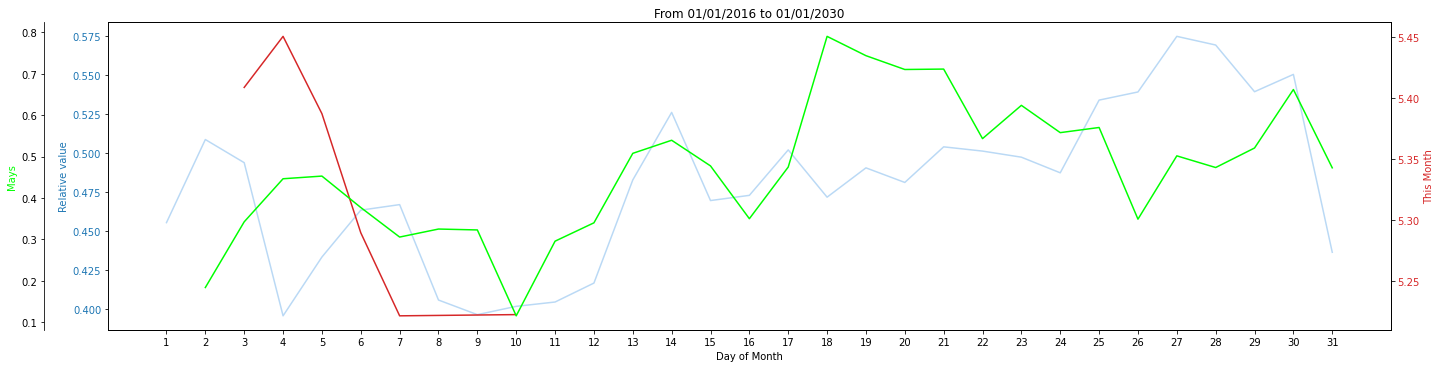

The day with HIGHEST value probability on MAY is the 18 with a value of 0.7904278852783957
The day with LOWEST value probability on MAY is the 10 with a value of 0.1157079850746952


In [8]:
x, y = zip(*lists) # unpack a list of pairs into two tuples

print('The Relative Value is between the min and max USD->BRL values in a given month\n')
print(f'Analysing for {current_date.strftime("%Y-%m-%d")}')
print(f'Green: Average of all {current_date.strftime("%B")}s\n\n')

fig, ax1 = plt.subplots(figsize=(20,5))
ax1.set_facecolor('white')

color = 'tab:blue'
ax1.set_xlabel('Day of Month')
ax1.set_ylabel('Relative value', color=color)
# ax1.ylim((0,1))
ax1.tick_params(axis='y', labelcolor=color)
color = '#bad9f5'
ax1.plot(x, y, color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('This Month', color=color)  # we already handled the x-label with ax1
ax2.plot(month_x, month_y, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'lime'
ax3.plot(month_old_x, month_old_y, color=color)
ax3.set_ylabel(f'{current_date.strftime("%B")}s', color=color)
ax3.spines["left"].set_position(("axes", -0.05))
ax3.spines["left"].set_visible(True)
ax3.yaxis.set_label_position('left')
ax3.yaxis.set_ticks_position('left')
# ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title(label="From {start} to {end}".format(start=start_date, end=end_date))
plt.show()

best_day = ordered_by_value[0]
print(f'The day with HIGHEST value probability on {current_date.strftime("%B").upper()} is the {str(best_day[0])} with a value of {str(best_day[1])}')
worst_day = ordered_by_value[-1]
print(f'The day with LOWEST value probability on {current_date.strftime("%B").upper()} is the {str(worst_day[0])} with a value of {str(worst_day[1])}')

In [9]:
import calendar
import numpy as np
calendar.setfirstweekday(6)

def get_week_of_month(year, month, day):
    x = np.array(calendar.monthcalendar(year, month))
    week_of_month = np.where(x==day)[0][0] + 1
    return(week_of_month)


def group_by_weekday(week_dict):
    output = {}
    
    return output

def by_weekday_and_week_of_month(month_dict):
    output = {}
    for month in month_dict:
        month_value = month_dict[month]
        for day in month_value:
            date = datetime.strptime(f"{month}-{day}", "%Y-%m-%d")
            week_of_month = get_week_of_month(date.year, date.month, date.day)
            weekday = date.weekday()
            rate = month_value[day]
#             print(f"{date} was a {calendar.day_abbr[weekday]} of week {week_of_month} with value {rate}")
            if week_of_month in output:
                if weekday in output[week_of_month]:
                    output[week_of_month][weekday].append(rate)
                else:
                    output[week_of_month][weekday] = [rate]
            else:
                output[week_of_month] = {}
                output[week_of_month][weekday] = [rate]
    return output

#### [week_of_month][weekday] = value


grouped_by_weekday = by_weekday_and_week_of_month(normalized_values)

# Num to ordinal function
# ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

def formatted_weekday(weekday, week_of_month):
    return f"{calendar.day_abbr[weekday]} ({week_of_month})"

def average_weekly(dictionary):
    output = {}
    for week_of_month in dictionary:
        weekdays = dictionary[week_of_month]
        avg_weekdays = average_dict_values(weekdays)
        output[week_of_month] = avg_weekdays
    return output

def formatted_week_dict(dictionary):
    output = {}
    for week_of_month in sorted(dictionary):
        weekdays = dictionary[week_of_month]
        for weekday in sorted(weekdays.keys()):
#             print(week_of_month)
            key = formatted_weekday(weekday,week_of_month)
#             print(key)
            output[key] = weekdays[weekday]
    return output

average_by_weekday = average_weekly(grouped_by_weekday)
weekday_x, weekday_y = zip(*formatted_week_dict(average_by_weekday).items())

average_this_month_weekly = average_weekly(by_weekday_and_week_of_month({current_month_key: grouped_values[current_month_key]}))
this_month_by_weekday = formatted_week_dict(average_this_month_weekly)
month_weekday_x, month_weekday_y = zip(*this_month_by_weekday.items())

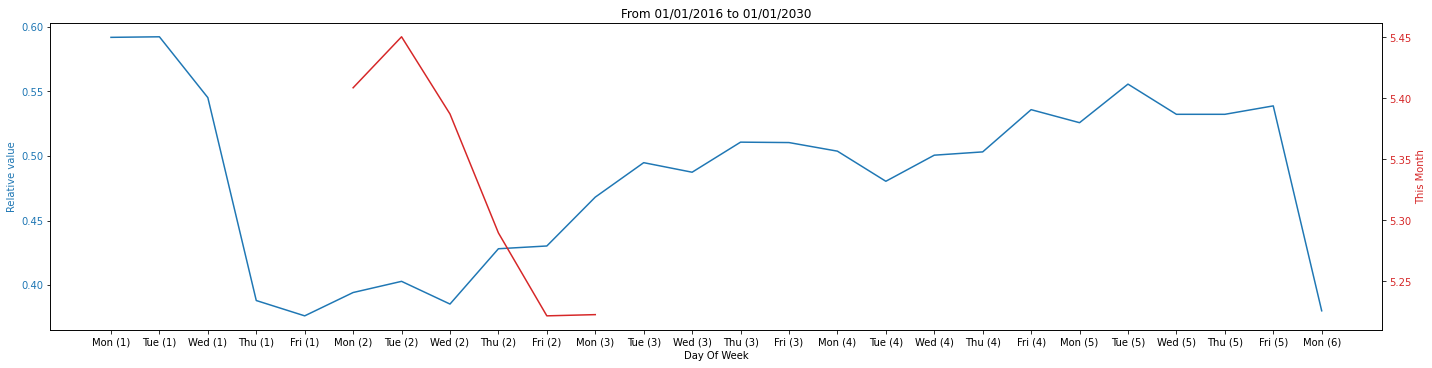

In [10]:
from matplotlib import ticker

fig, ax1 = plt.subplots(figsize=(20,5))

int_x_indexes = range(len(weekday_x))
# month_x_indexed = 

color = 'tab:blue'
ax1.set_xlabel('Day Of Week')
ax1.set_ylabel('Relative value', color=color)
# ax1.ylim((0,1))
ax1.plot(int_x_indexes, weekday_y, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(ticker.FixedLocator(int_x_indexes))
ax1.xaxis.set_major_formatter(ticker.FixedFormatter(weekday_x))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('This Month', color=color)  # we already handled the x-label with ax1
ax2.plot(list(map(lambda x: weekday_x.index(x), month_weekday_x)), month_weekday_y, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.xticks(np.arange(min(int_x_indexes), max(int_x_indexes)+1, 1.0))
plt.title(label="From {start} to {end}".format(start=start_date, end=end_date))
plt.show()

In [11]:
# grouped_by_weekday

def month_with_weekdays(year_and_month):
    output = {}
    for (day, value) in sorted(averaged_results.items()):
        try:
            date = datetime.strptime(f"{year_and_month}-{day}", "%Y-%m-%d")
        except ValueError:
            continue
        week_of_month = get_week_of_month(date.year, date.month, date.day)
        weekday = date.weekday()
        # print(f"{date}: {week_of_month} - {weekday} | Value: {value}")
        weekday_value = average_by_weekday[week_of_month].get(weekday)
        if weekday_value == None:
            continue
        rate = (weekday_value + value) / 2
        
        output[day] = rate
    return output

The Relative Value is between the min and max USD->BRL values in a given month


Light Blue: Average of all period
Blue: Average of all period normalized by weekday
Red: This month absolute value


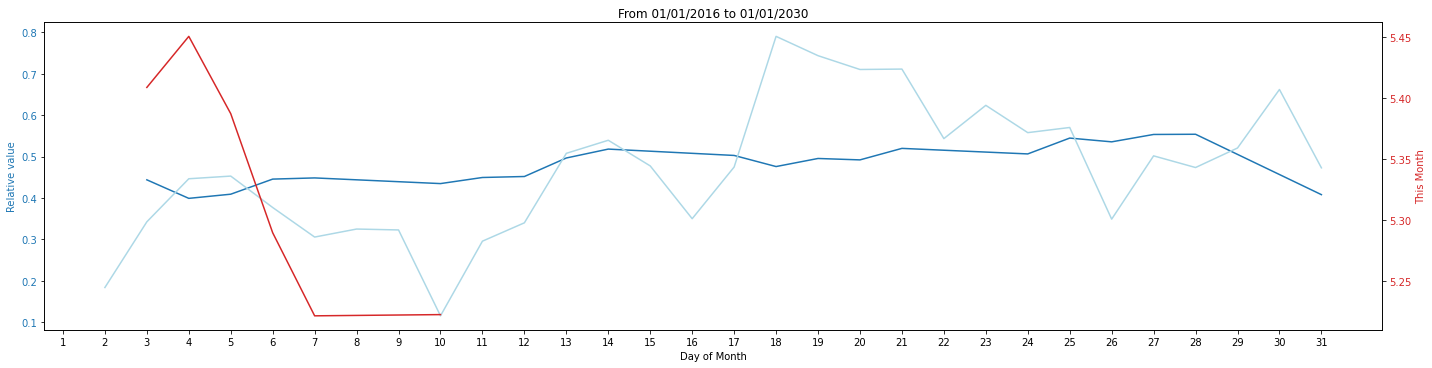

The day with HIGHEST value probability is the 28 with a value of 0.554088643480654
The day with LOWEST value probability is the 4 with a value of 0.39931928703971004


In [12]:
# x, y = zip(*lists) # unpack a list of pairs into two tuples
this_month_weekly = month_with_weekdays(current_date.strftime("%Y-%m"))
x2, y2 = zip(*sorted(this_month_weekly.items()))

print('The Relative Value is between the min and max USD->BRL values in a given month\n\n')

print('Light Blue: Average of all period')
print('Blue: Average of all period normalized by weekday')
print('Red: This month absolute value')

fig, ax1 = plt.subplots(figsize=(20,5))



color = 'tab:blue'

ax1.plot(x2, y2, color=color)
ax1.set_xlabel('Day of Month')
ax1.set_ylabel('Relative value', color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'lightblue'
ax1.plot(month_old_x, month_old_y, color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('This Month', color=color)  # we already handled the x-label with ax1
ax2.plot(month_x, month_y, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title(label="From {start} to {end}".format(start=start_date, end=end_date))
plt.show()

ordered_by_value = sorted(this_month_weekly.items(), key = operator.itemgetter(1),reverse = True)
best_day = ordered_by_value[0]
print('The day with HIGHEST value probability is the ' + str(best_day[0]) + ' with a value of ' + str(best_day[1]))
worst_day = ordered_by_value[-1]
print('The day with LOWEST value probability is the ' + str(worst_day[0]) + ' with a value of ' + str(worst_day[1]))